In [1]:
import sys
sys.path.append('/Users/sbhardwaj/Documents/GraphNodeClassification')

from src.models.models import GCN
from src.data.data_loader import DBLP_dataset
from src.utilities.utils import acc , recall , create_communities
import node2vec
import torch
import os
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Selecting device

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("mps device found")
else:
    device = "cpu"
    print ("MPS device not found.")

mps device found


## Loading unseen data

In [32]:
dataloader_args = {
    "root":os.path.abspath("..") + "/data",
    "raw_filenames":["graph_edges.txt" , "5000_communities.txt"],
    "expt":"edge_sampling",
    "processed_filenames":["data_nc_0.pt" , "data_nc_1.pt" , "data_nc_2.pt" , "data_nc_3.pt" ]
}

dataloader_args

{'root': '/Users/sbhardwaj/Documents/GraphNodeClassification/data',
 'raw_filenames': ['graph_edges.txt', '5000_communities.txt'],
 'expt': 'edge_sampling',
 'processed_filenames': ['data_nc_0.pt',
  'data_nc_1.pt',
  'data_nc_2.pt',
  'data_nc_3.pt']}

In [33]:
d_nc = DBLP_dataset(root = dataloader_args["root"] , raw_filenames = dataloader_args["raw_filenames"] ,
                    expt = "n_communities", processed_filenames = dataloader_args["processed_filenames"])

Processing...
Done!


In [23]:
data = torch.load(f"../data/processed/data_16_200_0.5.pt").to(device)
data

Data(x=[30732, 21], edge_index=[2, 142336], y=[30732, 200], dtype=torch.float32, g=Graph with 30732 nodes and 55802 edges, train_mask=[30732], val_mask=[30732], test_mask=[30732])

## Arguments for Node2Vec embedding generation and model

In [5]:
gcn_args = {
    'device': device,
    'num_layers': 4,
    'hidden_dim': 16,
    'dropout': 0.2,
    'lr': 0.005,
    'epochs': 1000,
}

gcn_args

{'device': device(type='mps'),
 'num_layers': 4,
 'hidden_dim': 16,
 'dropout': 0.2,
 'lr': 0.005,
 'epochs': 1000}

### Embeddings generation

### Loading model weights

In [6]:
model_path = "../models/gcn_16_200_0.5.pt"

loaded_model = GCN(data.x.shape[1] , gcn_args['hidden_dim'] , data.y.shape[1] , gcn_args['num_layers'] , gcn_args['dropout']).to(device)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Testing the output

In [7]:
y = loaded_model(data.x , data.edge_index)

loc("mps_not_equal"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":253:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W142336 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W142336 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe

In [87]:
c = (multilabel_confusion_matrix((data.y[data.train_mask].int()).cpu() , ((y>0.5)[data.train_mask].int()).cpu()))

In [89]:
recall(np.sum(c , axis=0))

0.9122773705996279

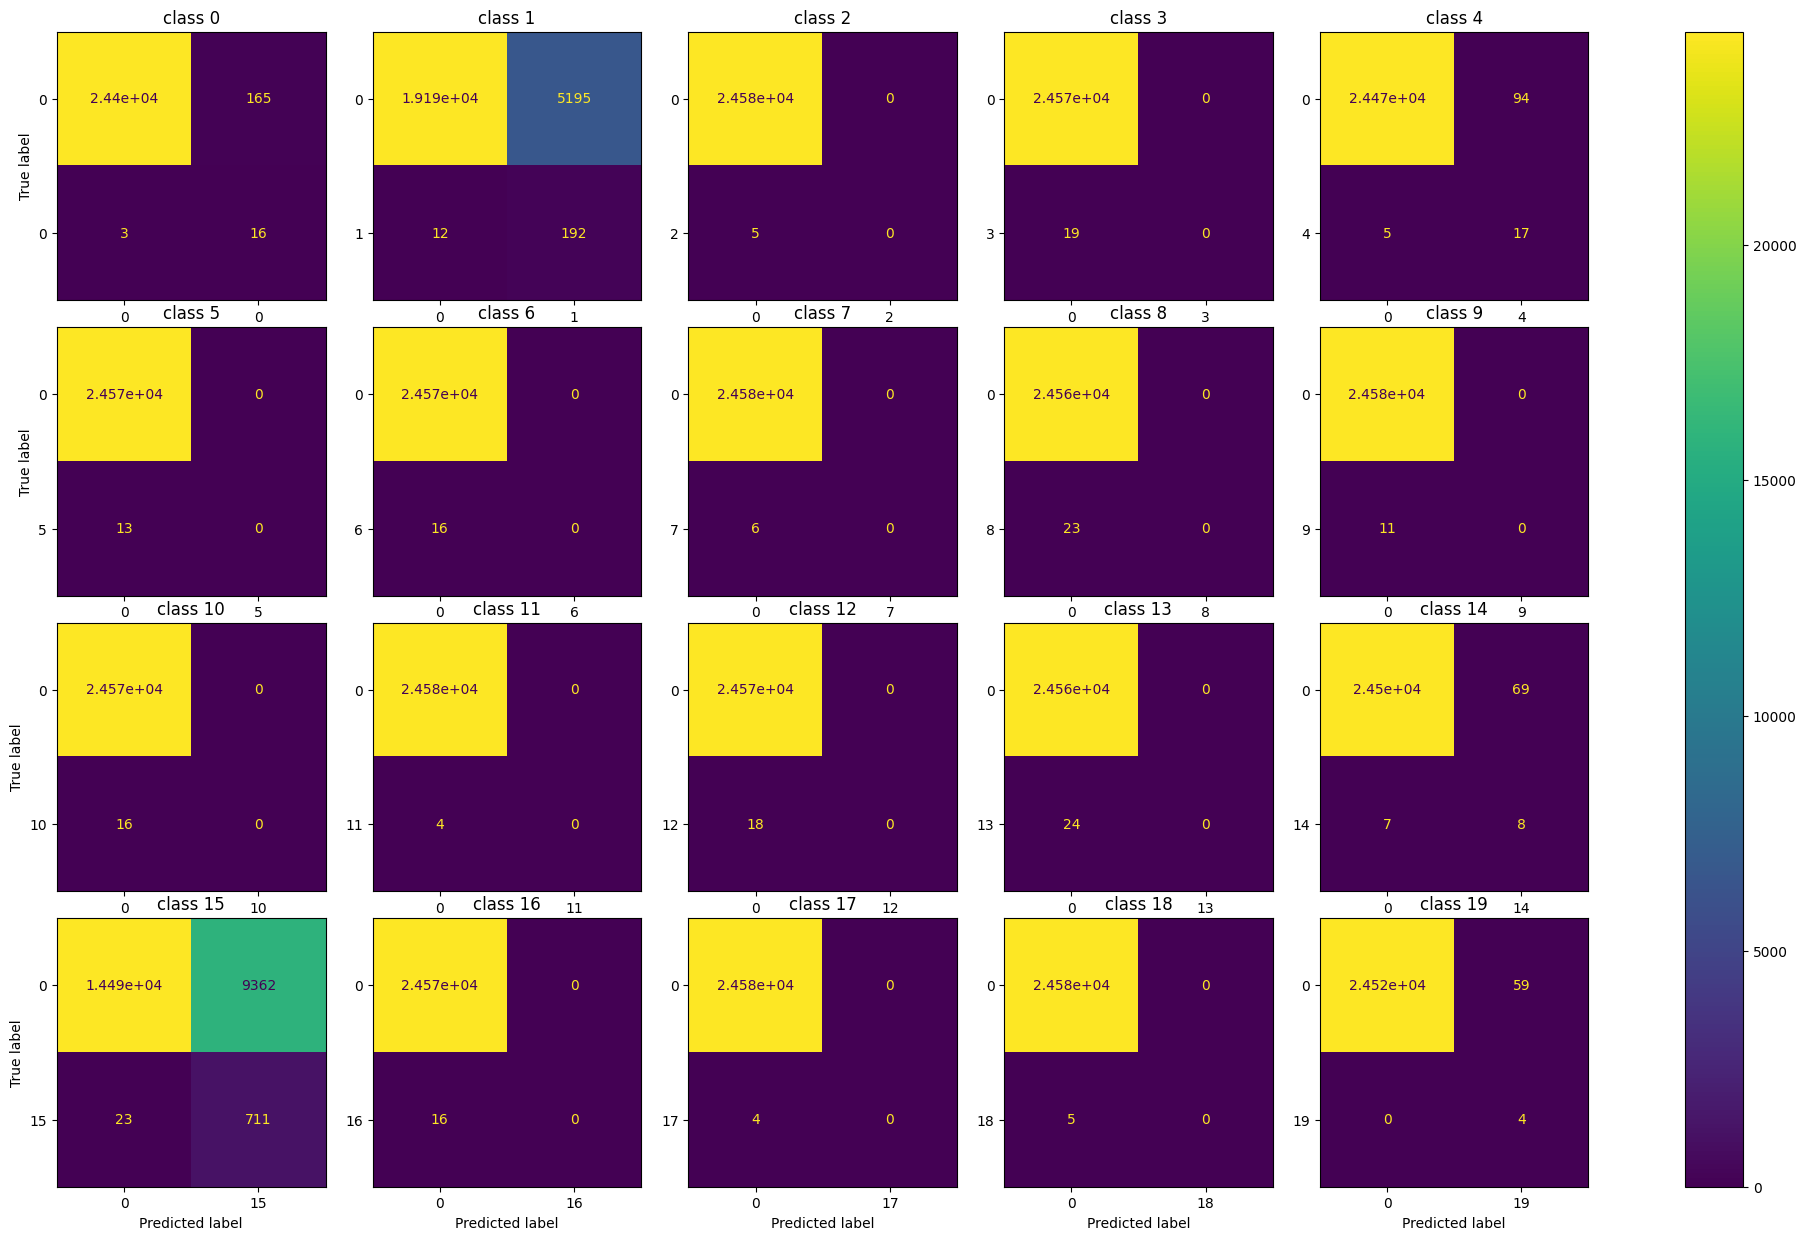

In [29]:
f, axes = plt.subplots(4, 5, figsize=(25, 15))
axes = axes.ravel()

for i in range(20):
    disp = ConfusionMatrixDisplay(c[i] , display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [11]:
comms = create_communities(y)
comms[0][:10]

[array([1.33690000e+04, 7.30972469e-01]),
 array([8.34500000e+03, 7.30927825e-01]),
 array([1.61600000e+03, 7.30859578e-01]),
 array([2.41340000e+04, 7.30779409e-01]),
 array([8.30500000e+03, 7.30606258e-01]),
 array([1.27210000e+04, 7.30377316e-01]),
 array([1.50560000e+04, 7.30278075e-01]),
 array([1.07650000e+04, 7.30068386e-01]),
 array([1.23000000e+04, 7.29815602e-01]),
 array([1.79700000e+04, 7.29623258e-01])]

In [15]:
data.x[13369]

tensor([-1.9769e+00, -2.5966e+00, -3.1735e-01,  2.1771e+00, -1.3521e+00,
         4.6838e-01, -2.6931e+00, -2.6803e+00, -3.0752e+00, -1.5348e+00,
         8.6588e-01,  2.7650e+00,  4.2547e-01, -9.8876e-01, -4.3232e-01,
        -1.1320e+00,  5.7043e-03,  2.0238e-03,  2.2951e-35,  0.0000e+00,
         0.0000e+00], device='mps:0')

In [17]:
y[13369]

tensor([0.7310, 0.2689, 0.2689, 0.2689, 0.2690, 0.2689, 0.2689, 0.2689, 0.2689,
        0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.5684, 0.2697, 0.2689, 0.2689,
        0.2689, 0.2689, 0.2689, 0.2691, 0.2689, 0.2689, 0.7293, 0.2689, 0.2689,
        0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.7311,
        0.2689, 0.7265, 0.2689, 0.2689, 0.2689, 0.7311, 0.2689, 0.2689, 0.2689,
        0.2689, 0.2689, 0.3515, 0.2689, 0.2689, 0.6431, 0.2689, 0.2689, 0.2689,
        0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.7311, 0.2689, 0.2689, 0.2689,
        0.2689, 0.2689, 0.2689, 0.2689, 0.6012, 0.7311, 0.2694, 0.2689, 0.2693,
        0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.7311, 0.2689, 0.2689, 0.2689,
        0.2713, 0.2689, 0.7308, 0.2689, 0.7311, 0.2689, 0.2689, 0.2689, 0.2689,
        0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
        0.2689, 0.2698, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
        0.2690, 0.2689, 0.2689, 0.2689, 